## Step 1
### About the Dataset

Polaris ([polarishub.io](https://polarishub.io/datasets/asap-discovery/antiviral-potency-2025-unblinded)) is an open-source platform that provides high-quality datasets for machine learning in drug discovery.

The chosen dataset ([source](https://asapdiscovery.org/pipeline/)) contains 1,328 pIC50 values against both the MERS-CoV Mpro target and the SARS-CoV-2 Mpro target. I've chosen this as it is intended to reflect a realistic dataset used in drug discovery settings, unlike other sources such as the [MoleculeNet](https://moleculenet.org/) datasets, which have been criticised for their flaws (see [this blogpost](https://practicalcheminformatics.blogspot.com/2023/08/we-need-better-benchmarks-for-machine.html) by Pat Walters).

This dataset was used in a blind challenge, with the dataset split into training and test, which is labelled in the 'set' column. Here, I will hold out the test set entirely until after completing my cross-validation (CV) procedure. i.e. I will conduct my training and CV procedure on the datapoints labelled 'train', then will test the performance of the model on the 'test' datapoints.

Some issues have been highlighted with this dataset. In particular, some enantiomers were given the same SMILES strings, so even if they had different bioactivities, a machine learning model wouldn't be able to distinguish between the two. As such, I will filter out those cases when testing the model, as was done for the challenge.

In [1]:
from data.dataset import dataset, dataset_df

dataset_df

/Users/femisegvn/Coding/miniconda3/envs/antiviral-pot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,CXSMILES,Molecule Name,Set,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro)
0,COC[C@]1(C)C(=O)N(C2=CN=CC3=CC=CC=C23)C(=O)N1C...,ASAP-0000141,Train,4.19,NaN
1,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000142,Train,4.92,5.29
2,CNC(=O)CN1C[C@]2(C[C@H](C)N(C3=CN=CC=C3C3CC3)C...,ASAP-0000143,Train,4.73,NaN
3,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000144,Train,4.90,6.11
4,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000145,Train,4.81,5.62
...,...,...,...,...,...
1323,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1[C@H]1CCC...,ASAP-0032561,Test,4.54,4.20
1324,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1[C@H]1CCC...,ASAP-0032562,Test,4.42,NaN
1325,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H]2CCCC[C@@H]...,ASAP-0032572,Test,4.84,5.18
1326,COC1=CC=CC=C1[C@H]1C[C@H](C)CCN1C(=O)CC1=CN=CC...,ASAP-0032604,Test,5.53,5.59


## Step 2

### Data Preprocessing

As mentioned in the previous step, indistinct enantiomers need to be removed. Polaris noted entries `1036, 1039, 1219, 1225, 1306`, but I will verify that these are the only cases of such. Multiple SMILES strings can be used to represent the same molecule so I will canonicalise the smiles by transforming them into an `rdkit.mol` object and transforming that back into a SMILES string. I will be checking for other duplicate ent.

My cleaning process is as follows:
1. remove entries `1036, 1039, 1219, 1225, 1306`
2. canonicalise CXSMILES
3. Check for duplicates in training and test data 
    - if duplicates occur within the training set, merge them and use the mean of their pIC50 values
    - if duplicates occur in the test set ???
    - if a duplicate has one in the the training set and one in the test set, remove this entry entirely -- entries
    shouldn't be present in both the training and test set. Thankfully, we found no overlap between training and test

In [2]:
# First of all, I will remove the datapoints that Polaris as recommended to be removed from the dataset
dataset_df = dataset_df.drop([1036,1039,1219,1225,1306], axis=0)

In [3]:
# Here we canonicalise the smiles, ensuring a consistent systematic representation across all molecules
from utils import canonicalise_smiles
dataset_df.CXSMILES = canonicalise_smiles(dataset_df.CXSMILES)

In [4]:
# Checking for duplicates we see 172 rows of multiple instances of a CXSMILES
smiles = dataset_df.CXSMILES
duplicates = dataset_df[smiles.duplicated(keep=False)]
duplicates

,CXSMILES,Molecule Name,Set,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro)
37,C[C@H]1CC[C@@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2C...,ASAP-0000180,Train,4.57,4.65
38,C[C@H]1CC[C@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2C1...,ASAP-0000181,Train,4.69,4.37
39,C[C@H]1CC[C@@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2C...,ASAP-0000182,Train,4.34,4.21
40,C[C@H]1CC[C@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2C1...,ASAP-0000183,Train,4.76,NaN
69,CO[C@H]1CC[C@@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2...,ASAP-0000228,Train,4.23,4.22
...,...,...,...,...,...
1322,O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1[C@H]1CCCO1 |o...,ASAP-0032560,Test,4.33,4.02
1323,O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1[C@H]1CCCO1 |o...,ASAP-0032561,Test,4.54,4.20
1324,O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1[C@H]1CCCO1 |o...,ASAP-0032562,Test,4.42,NaN
1326,COc1ccccc1[C@H]1C[C@H](C)CCN1C(=O)Cc1cncc2cccc...,ASAP-0032604,Test,5.53,5.59


In [5]:
# Check the dataset to see if any SMILES in the training set are repeated in the test set
from utils import train_test_overlap
overlap = train_test_overlap(dataset_df)
overlap


set()

In [6]:
# Merge duplicate entries finding the mean of their pIC50s
from utils import merge_duplicates

dataset_df_clean = merge_duplicates(dataset_df)
dataset_df_clean

,CXSMILES,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro),Molecule Name,Set
0,C#CC(=O)N1CCN(Cc2cccc(Cl)c2)[C@H]2CS(=O)(=O)C[...,4.600,5.32,ASAP-0016438,Train
1,C#CC1(C)CCN(C(=O)Cc2cncc3ccccc23)CC1,4.990,5.33,ASAP-0031776,Train
2,C#Cc1ccc(NC(=O)C=C)cc1N(Cc1cccc(Cl)c1)C(=O)Cc1...,4.460,NaN,ASAP-0013314,Train
3,C#Cc1ccc([C@H]2CCCCN2C(=O)Cc2cncc3ccccc23)cc1 ...,5.660,4.85,ASAP-0032181,Test
4,C#Cc1ccc2c(c1)[C@H](C(=O)Nc1cncc3ccccc13)CN(C)...,4.425,4.66,ASAP-0008477,Train
...,...,...,...,...,...
1235,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1nnco1)C(=O)N(c1cn...,6.630,7.13,ASAP-0015916,Train
1236,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1nnco1)C(=O)N(c1cn...,6.810,7.30,ASAP-0017058,Test
1237,O=[S@](Cc1cccc(Nc2ncnc3[nH]ccc23)c1)c1ccccc1 |...,4.940,NaN,ASAP-0000269,Train
1238,O=c1c(-c2cccc(Cl)c2)cnc(S)n1-c1cncc2ccccc12,5.040,6.86,ASAP-0000171,Train


COC[C@]1(C)C(=O)N(c2cncc3ccccc23)C(=O)N1C |&1:3|


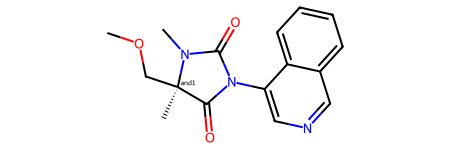

COC[C@]1(C)C(=O)N(c2cncc3ccccc23)C(=O)N1C |&1:3|


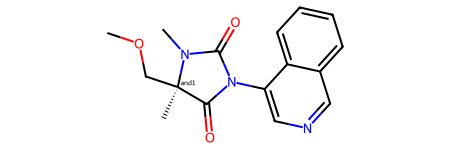

COC[C@]1(C)C(=O)N(c2cncc3ccccc23)C(=O)N1C


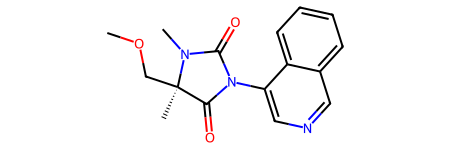

In [7]:
from rdkit import Chem
s = dataset_df.CXSMILES[0]
print(s)
mol = Chem.MolFromSmiles(s)
display(mol)

s = Chem.MolToCXSmiles(mol)
print(s)
mol=Chem.MolFromSmiles(s)
display(mol)

s = Chem.MolToSmiles(mol)
print(s)
mol=Chem.MolFromSmiles(s)
display(mol)



#### Food for thought
Canonicalising these CXSMILES made me think of a couple things. 

1. It's interesting that aromatic systems in (CX)SMILES representation can be represented as a kekule structure e.g. in `(C2=CN=CC3=CC=CC=C23)`, but also as a delocalised system e.g. `(c2cncc3ccccc23)`.

2. `rdkit` appears to eliminate the extra information provided by a *CX*SMILES when converting from the `rdkit.mol` object into a SMILES via `Chem.MolToSmiles()`. How much does this extra information provided by CXSMILES matter? It *can* be kept by using `Chem.MoltoCXSmiles()`. How can we use the extra information from CXSmiles to build a better model?

## Step 3

### Dataset Exploration

/Users/femisegvn/Chem/antiviral-potency/utils.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


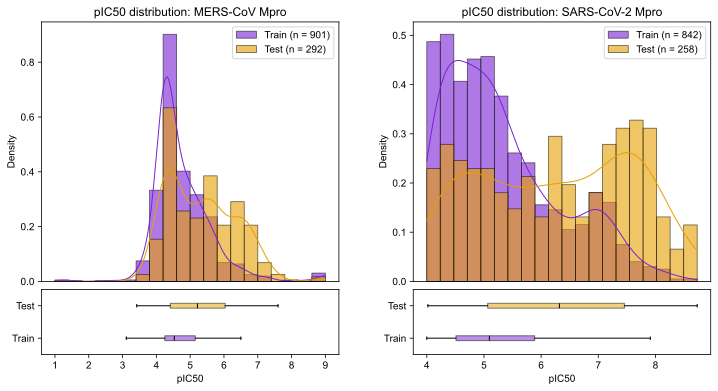

In [8]:
from utils import hist_plot
%config InlineBackend.figure_format = 'svg'
hist_plot(dataset_df)

#### A comment on the distributions

For both endpoints, the test set has a broader, more sparse distribution than the training set. This will challenge the predictive power of the model, as ML regressors tend to perform less well out of the training distribution.

Furthermore, the training data in both cases tends to have more negative skew than the the test data. Looking at the boxplots, the training sets have a median value closer to the lower quartile, and the lowere quartile much closer to the minimum than the upper quartile is to the maximum. I am defo gonna have to reword this because it is so unclear. On the other hand, the test sets have a median that falls pretty much exactly in the middle of the distribution, with a more symmetrical boxplot overall.

Given that the data is not normally distributed, it doesn't make sense to apply a standard scaler to this dataset. As recommended in the `scikit-learn` documentation, I will employ the `MaxAbsScaler` which is specifically designed for scaling sparse data.

/Users/femisegvn/Chem/antiviral-potency/utils.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


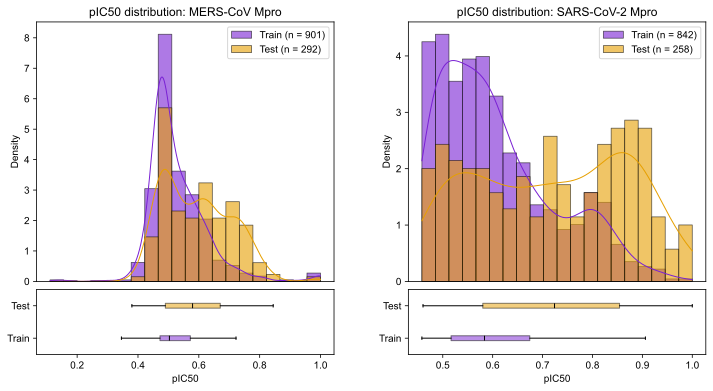

In [9]:
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
mers_scaler = MaxAbsScaler()
sars_scaler = MaxAbsScaler()

mers_pIC50 = np.array(dataset_df['pIC50 (MERS-CoV Mpro)']).reshape(-1, 1)
sars_pIC50 = np.array(dataset_df['pIC50 (SARS-CoV-2 Mpro)']).reshape(-1, 1)

dataset_df['pIC50 (MERS-CoV Mpro) scaled'] = mers_scaler.fit_transform(mers_pIC50)
dataset_df['pIC50 (SARS-CoV-2 Mpro) scaled'] = sars_scaler.fit_transform(sars_pIC50)

hist_plot(dataset_df, mers_col = "pIC50 (MERS-CoV Mpro) scaled",
          sars_col = "pIC50 (SARS-CoV-2 Mpro) scaled")

#### Transformed Distributions
The distributions look pretty much identical but now all the values are between 0 and 1, and as a consequence the density of values is much higher. This could be more suitable for training a neural network however, having tried both without and with the scaled values, I don't think there's any significant benefit to either approach.

## Step 4

### Model Training and Cross Validation

In [10]:
train = dataset_df[dataset_df.Set == "Train"]
test = dataset_df[dataset_df.Set == "Test"]

mers_train = train[["CXSMILES", "pIC50 (MERS-CoV Mpro) scaled"]].dropna()
mers_test = test[["CXSMILES", "pIC50 (MERS-CoV Mpro) scaled"]].dropna()

sars_train = train[["CXSMILES", "pIC50 (SARS-CoV-2 Mpro) scaled"]].dropna()
sars_test = test[["CXSMILES", "pIC50 (SARS-CoV-2 Mpro) scaled"]].dropna()


### MERS Model
Featurisation with `featurise()`
Model training and benchmarking with a 5 x 5 CV procedure.

In [11]:
from utils import featurise, cross_validation
import numpy as np

mols = [Chem.MolFromSmiles(s) for s in mers_train.CXSMILES]
X = featurise(mols, scheme='rdkit_frags')
y = np.asarray(mers_train["pIC50 (MERS-CoV Mpro) scaled"], dtype = float)

fold_metrics = cross_validation(X, y, model="MLP", scaler=mers_scaler)

5x5 CV Results:
R^2 : mean=-0.070  std=0.111
MAE : mean=0.605  std=0.041
RMSE: mean=0.909  std=0.068


### SARS Model

Featurisation with `featurise()`, followed by training and benchmarking with a 5 x 5 CV procedure

In [12]:
from utils import featurise, cross_validation
import numpy as np

mols = [Chem.MolFromSmiles(s) for s in sars_train.CXSMILES]
X = featurise(mols, scheme = "rdkit_frags")
y = np.asarray(sars_train["pIC50 (SARS-CoV-2 Mpro) scaled"], dtype = float)

fold_metrics = cross_validation(X, y, model="MLP", scaler=sars_scaler)


5x5 CV Results:
R^2 : mean=0.443  std=0.108
MAE : mean=0.561  std=0.043
RMSE: mean=0.743  std=0.060


## Step 5

### Performance

Conduct one training cycle on the full training set and predict on the test set

### MERS Model Test

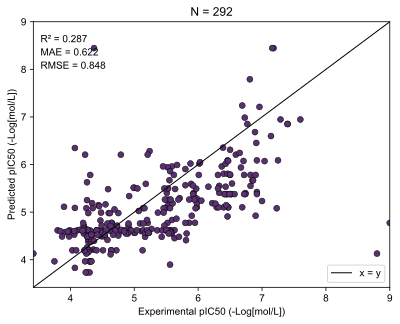

In [13]:
from utils import featurise, test_model, scatter_plot

train_mols = [Chem.MolFromSmiles(s) for s in mers_train.CXSMILES]
test_mols = [Chem.MolFromSmiles(s) for s in mers_test.CXSMILES]

X_train = featurise(train_mols, scheme = "rdkit_frags")
X_test = featurise(test_mols, scheme = "rdkit_frags")

y_train = np.asarray(mers_train["pIC50 (MERS-CoV Mpro) scaled"], dtype = float)
y_test = np.asarray(mers_test["pIC50 (MERS-CoV Mpro) scaled"], dtype = float)

test, pred = test_model(X_train, X_test, y_train, y_test, model = "MLP", scaler=mers_scaler)

scatter_plot(test, pred)

### SARS Model Test

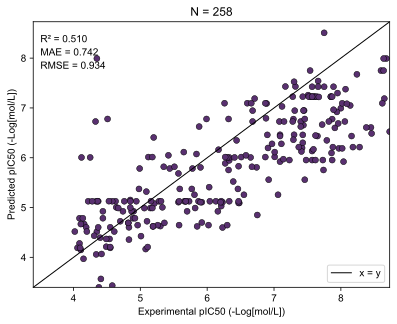

In [14]:
from utils import test_model, scatter_plot

train_mols = [Chem.MolFromSmiles(s) for s in sars_train.CXSMILES]
test_mols = [Chem.MolFromSmiles(s) for s in sars_test.CXSMILES]

X_train = featurise(train_mols, scheme = "rdkit_frags")
X_test = featurise(test_mols, scheme = "rdkit_frags")

y_train = np.asarray(sars_train["pIC50 (SARS-CoV-2 Mpro) scaled"], dtype = float)
y_test = np.asarray(sars_test["pIC50 (SARS-CoV-2 Mpro) scaled"], dtype = float)

test, pred = test_model(X_train, X_test, y_train, y_test, model = "MLP", scaler=sars_scaler)

scatter_plot(test, pred)

## Step 6

### Feature engineering
In general, will try a few different approaches;
1. Morgan Fingerprint
2. 2D RDKit descriptors
3. RDKit Fragments
4. Hybrid approach: Some combination of the best findings from the above approaches


### MLPs: A Love Hate Relationship

Listen MLPs, I love you, but you drive me insane. I try to give you everything I have, all the features I can, then you tell me I'm not enough. It's breaking my heart, and we're gonna have to part ways. For one last rodeo, I will document everything I've tried, before I move onto `XGBRegressor`.

Reporting the 5x5 CV results and final test results on both the MERS and the SARS data. All using an MLP `MLPRegressor(hidden_layer_sizes=(128,128), activation='relu', learning_rate="adaptive")`

#### 1. Morgan Fingerprint, radius = 3, bits = 1024

MERS 5x5 CV Results: 
- R^2 : mean=-0.275    std=0.172
- MAE : mean=0.685   std=0.043
- RMSE: mean=0.991  std=0.071

MERS Test:
- R^2 : 0.139
- MAE : 0.671
- RMSE: 0.932


SARS 5x5 CV Results:
- R^2 : mean=0.336    std=0.128
- MAE : mean=0.612   std=0.053
- RMSE: mean=0.812  std=0.084

SARS Test:
- R^2 : 0.388
- MAE : 0.815
- RMSE: 1.044

Comments:

It's interesting that in the MERS CoV dataset, the R^2 was very poor in CV (R^2 = -0.275), but performance on the Test set was less poor R^2 = 0.130. At first I thought there was a mistake being made, but upon inspection of the scatter plots, the R^2 for the CV is so poor because the 'train' dataset is more bunched up and clustered, but is better for the test dataset because the datapoints are more sparse and a loose correlation can be seen. This is supported by the MAE being very similar in both the CV and the Test, highlighting the important distinction between correlation and error metrics.

In the SARS-CoV-2 dataset, performance across the CV protocol and the Test set was much more closely matched, but overall the error metrics were very poor. Seeking out better performance, I will look into rdkit featurisation. 


#### 2. RdKit Features

Picking select features that could be significant indicators of efficacy against Mpro. Started with the following 5 as a baseline:

- Molecular Weight
- TPSA
- No. H Acceptors
- No. H Donors
- Crippen LogP

This was so bad it was unbelievable. So I thought perhaps there were not enough descriptors for such a complex relationship. When trying all 217 descriptors (via `Descriptors.CalcMolDescriptors()`) -- nonsensical results like predicting pIC50 = 10^13. I found a really large value in the descriptor matrix somewhere which might be responsible. I tried an iterative approach of adding descriptors, trying to be strategic about it, but nothing was making any significant improvements. Here are the results I obtained with the following descriptors:

- Molecular Weight
- TPSA
- No. H Acceptors
- No. H Donors
- Crippen LogP
- Number of Valence electrons
- Max and Min Partial Charge
- Max and Min Abs E State Index

##### MERS 
**5x5 CV Results:**
- R^2 : mean=-1.183    std=1.163
- MAE : mean=0.906   std=0.258
- RMSE: mean=1.258  std=0.268

**Test results**
- R^2 : -0.908
- MAE : 1.101
- RMSE: 1.387

##### SARS
**5x5 CV Results:**
- R^2 : mean=-0.936    std=1.564
- MAE : mean=1.038   std=0.398
- RMSE: mean=1.330  std=0.459

**Test results**
- R^2 : -0.304
- MAE : 1.230
- RMSE: 1.524

And it was at this stage I checked out of the relationship

#### 3. RdKit Fragments
A one-hot encoded input of the fragment counts of the input molecule. Based on the idea that the presence of some molecule fragments can significantly affect binding affinity to the target.

##### MERS 
**5x5 CV Results:**
- R^2 : mean=-0.055    std=0.131
- MAE : mean=0.607   std=0.030
- RMSE: mean=0.902  std=0.069

**Test results**
- R^2 : 0.270
- MAE : 0.637
- RMSE: 0.858

##### SARS
**5x5 CV Results:**
- R^2 : mean=0.443    std=0.100
- MAE : mean=0.567   std=0.038
- RMSE: mean=0.743  std=0.050

**Test results**
- R^2 : 0.437
- MAE : 0.809
- RMSE: 1.001


#### 4. Hybrid approach
After trying all of the above, I thought that I could combine the learnings from all three to try and achieve better predictive ability.
But given how much trouble MLPs were giving me, I saved this energy for XGboost.


### XGBoost: Stability

Moving onto XGBoost as I suspect it will bring me more peace.

Visualise everything I tried in a plot and then take the best one through for hyperparameter optimisation

### Hyperparameter optimisation
